In [41]:
# The Python standard library import
import numpy as np
import sys
import os
import shutil
from pathlib import Path
print(str(Path().resolve()))
current_dir = str(Path().resolve())
sys.path.append(os.path.join(current_dir, '..'))

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from operator import attrgetter


# The NEAT-Python library imports
import modneat
# The helper used to visualize experiment results
from modneat import visualize

/home/kato-masahiro/Project/velocity_2ol


In [35]:
checkpoint_path = '/home/kato-masahiro/Project/velocity_2ol/neo_result/[CONTINUED]velocity_task.velocity_task_N_ModExHebbFFN_lv1/checkpoints/checkpoint-399'

p = modneat.Checkpointer.restore_checkpoint(checkpoint_path)
p.config.genome_config.enabled_mutate_rate
population_list = list(p.population.values())
population_list = sorted(population_list, key=attrgetter('fitness'))
best_individual = population_list[-1]

In [132]:
print(best_individual)

Key: 141803
Fitness: -0.20350305376944983
Nodes:
	0 ModNodeGene(key=0, bias=-2.1046531915442106, response=1.0, activation=sigmoid, aggregation=sum, modulatory=False)
Connections:
	DefaultConnectionGene(key=(-1, 0), weight=4.162293617712821, enabled=True)
Global params:
	ExHebbGlobalGene(key=0, eta=-0.6687420769766534, a=-0.06547216468495856, b=1.1197124368281566, c=-0.21407774355926495, d=1.1307651528451124, m_d=0.0)


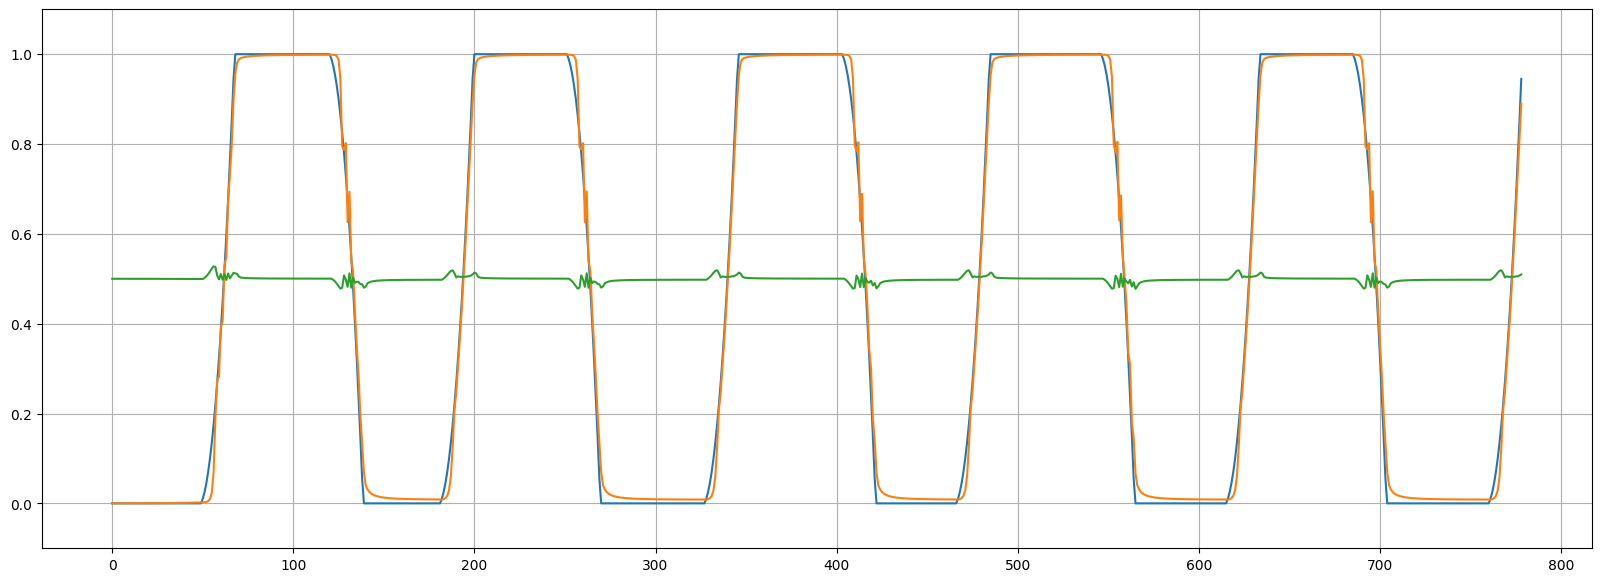

In [36]:
#print(best_individual.history)

for loop_list in best_individual.history:
    target_list = [d['target'] for d in loop_list]
    output_list = [d['output'][0] for d in loop_list]
    input_list = [d['input'] for d in loop_list]
    xlabel = [n for n in range(len(input_list))]
    #print(target_list)
    #print(output_list)
    fig = plt.figure(figsize=(20,7))
    plt.plot(xlabel, target_list)
    plt.plot(xlabel, output_list)
    plt.plot(xlabel, input_list)
    plt.ylim(-0.1,1.1)
    plt.grid()
    plt.show()

---


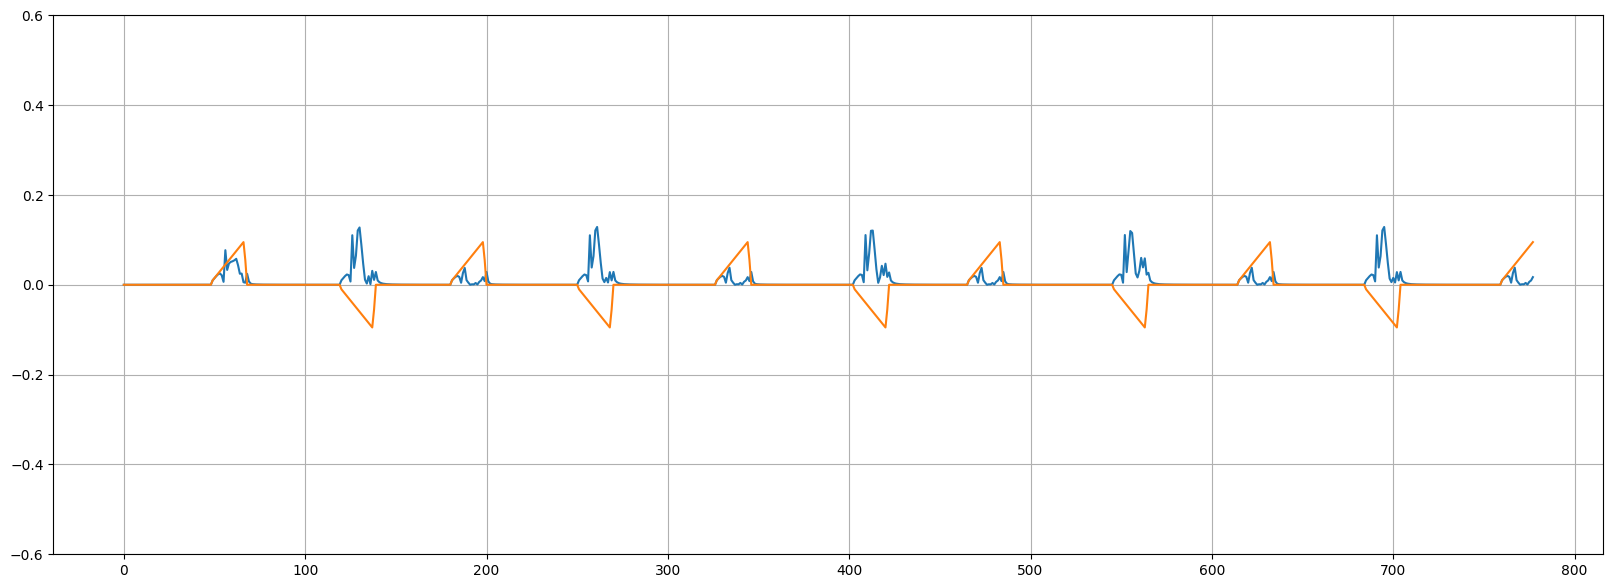

In [37]:
# モデルの学習効果、学習速度を可視化
for loop_list in best_individual.history:
    target_list = [d['target'] for d in loop_list]
    output_list = [d['output'][0] for d in loop_list]
    input_list = [d['input'] for d in loop_list]

    ideal_diff_list = []
    for i in range(len(target_list) -1):
        ideal_diff_list.append(target_list[i+1] - target_list[i])

    actual_diff_list = []
    for i in range(len(output_list) -1):
        actual_diff_list.append(output_list[i+1] - output_list[i])

    diff_diff_list = []
    for i in range(len(ideal_diff_list)):
        diff_diff_list.append(abs(ideal_diff_list[i] - actual_diff_list[i]))
    #print(ideal_diff_list)
    #print(actual_diff_list)
    #print(diff_diff_list)
    print("---")
    xlabel = [n for n in range(len(input_list) -1)]
    #print(target_list)
    #print(output_list)
    fig = plt.figure(figsize=(20,7))
    plt.plot(xlabel, diff_diff_list)
    #plt.plot(xlabel, actual_diff_list)
    plt.plot(xlabel, ideal_diff_list)
    plt.ylim(-0.6,0.6)
    plt.grid()
    plt.show()

In [42]:
# 二次学習能力(長期)
#学習能力が長期的に(生涯スケールで)どの程度改良されていくかを定量化したもの
for loop_list in best_individual.history:

    # historyから各要素のリストを作成する
    target_list = [d['target'] for d in loop_list]
    output_list = [d['output'][0] for d in loop_list]
    input_list = [d['input'] for d in loop_list]

    # 理想的な行動変化を示すリストを作成
    ideal_diff_list = []
    for i in range(len(target_list) -1):
        ideal_diff_list.append(target_list[i+1] - target_list[i])

    # 実際のエージェントの行動変化を示すリストを作成
    actual_diff_list = []
    for i in range(len(output_list) -1):
        actual_diff_list.append(output_list[i+1] - output_list[i])

    # 理想リストと実際のリストの差を作成
    diff_diff_list = []
    for i in range(len(ideal_diff_list)):
        diff_diff_list.append(abs(ideal_diff_list[i] - actual_diff_list[i]))
    
    # diff_range_listとして、変動が開始したステップ数を要素として持つリストを作成
    tmp_list=[]
    for i in range(len(ideal_diff_list)):
        if not(ideal_diff_list[i] == 0 or ideal_diff_list[i] == 1):
            tmp_list.append(i)
    tmp_list.append(len(ideal_diff_list))
    diff_range_list = []
    diff_range_list.append(tmp_list[0])
    for i in range(len(tmp_list) -1):
        if not( abs(tmp_list[i] - tmp_list[i+1]) == 1):
            diff_range_list.append(tmp_list[i])
            diff_range_list.append(tmp_list[i+1])
    diff_range_list.append(tmp_list[-1])
    
    print(diff_range_list)

    # resultとして、変動幅([開始ステップ、終了ステップ] のリスト)を要素として持つリストを作成
    result=[]
    for i in range(0, len(diff_range_list) -1 , 2):
        result.append([diff_range_list[i], diff_range_list[i+1]])
    
    print(result)
    # resultを利用していろいろ可視化
    partial_diff_list = []
    long_term_2ol_effect = []
    for pair in (result):
        #print(ideal_diff_list[pair[0]:pair[1]])
        #print(actual_diff_list[pair[0]:pair[1]])

        # 長期的な二次学習の効果を可視化
        long_term_2ol_effect.append(sum(diff_diff_list[pair[0]:pair[1]]))

        # 短期的な二次学習の効果を可視化
        short_term_2ol_effect = diff_diff_list[pair[0]:pair[1]]
        # 移動平均を求める
        df = pd.DataFrame(short_term_2ol_effect, columns=['value'])
        ma = df['value'].rolling(window=5).mean()

        xlabel = [n for n in range (len(short_term_2ol_effect))]
        fig = plt.figure(figsize=(14,7))
        plt.plot(xlabel, short_term_2ol_effect)
        plt.plot(xlabel, ma)
        plt.ylim(-0,0.2)
        plt.grid()
        plt.show()
        

[49, 67, 120, 138, 181, 199, 251, 269, 327, 345, 403, 421, 466, 484, 546, 564, 615, 633, 685, 703, 760, 778]
[[49, 67], [120, 138], [181, 199], [251, 269], [327, 345], [403, 421], [466, 484], [546, 564], [615, 633], [685, 703], [760, 778]]


AttributeError: module 'numpy' has no attribute 'moving_average'